In [62]:
import tensorflow as tf
# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')
#
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

import pathlib
from IPython import display
import functools
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
# from mitdeeplearning import as mdl
import cv2 as cv
import funcs as ff
from VAE import VAE

# check that the environment is fine
print('tf version : ', tf.__version__ )
print('np version : ', np.__version__ )
print('opencv version', cv.__version__)


tf version :  2.4.0-rc0
np version :  1.20.1
opencv version 4.5.1


In [63]:
# ###############
# DATASET CREATION
# ###############

# data import
img_h = 128
img_w = 128

batch_size = 64

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

def preprocess_images(images):
    return images.reshape((images.shape[0], 128, 128, 3)) / 255.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(img_h, img_w),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(img_h, img_w),
  batch_size=batch_size)
class_names = train_ds.class_names
print('class names : ', class_names)

# checking that the dataset has the expected shape
for batch, labels in train_ds:
    one_hot_labels = tf.one_hot(indices=labels, depth=len(class_names), dtype=tf.int32)
    print('train_ds batch shape : ', batch.shape)
    print('train_ds labels shape : ', one_hot_labels.shape)
    break

for batch, labels in val_ds:
    one_hot_labels = tf.one_hot(indices=labels, depth=len(class_names), dtype=tf.int32)
    print('valid_ds batch shape : ', batch.shape)
    print('valid_ds labels shape : ', one_hot_labels.shape)
    break

3670
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
class names :  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
train_ds batch shape :  (64, 128, 128, 3)
train_ds labels shape :  (64, 5)
valid_ds batch shape :  (64, 128, 128, 3)
valid_ds labels shape :  (64, 5)


original label :  tf.Tensor(2, shape=(), dtype=int32)
one hot label :  tf.Tensor([0 0 1 0 0], shape=(5,), dtype=int32)
image shape :  (128, 128, 3)
original label :  tf.Tensor(4, shape=(), dtype=int32)
one hot label :  tf.Tensor([0 0 0 0 1], shape=(5,), dtype=int32)
image shape :  (128, 128, 3)
original label :  tf.Tensor(3, shape=(), dtype=int32)
one hot label :  tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int32)
image shape :  (128, 128, 3)
original label :  tf.Tensor(0, shape=(), dtype=int32)
one hot label :  tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int32)
image shape :  (128, 128, 3)
original label :  tf.Tensor(1, shape=(), dtype=int32)
one hot label :  tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int32)
image shape :  (128, 128, 3)
original label :  tf.Tensor(1, shape=(), dtype=int32)
one hot label :  tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int32)
image shape :  (128, 128, 3)
original label :  tf.Tensor(4, shape=(), dtype=int32)
one hot label :  tf.Tensor([0 0 0 0 1], shape=(5,), dtype=

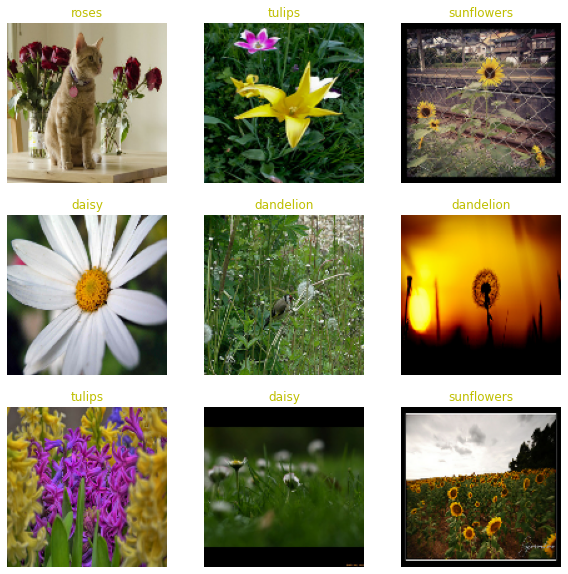

In [64]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    title_obj = plt.title(class_names[labels[i]])
    plt.setp(title_obj, color='y')
    plt.axis("off")
    print('original label : ', labels[i])
    print('one hot label : ',  tf.one_hot(indices=labels[i], depth=len(class_names), dtype=tf.int32))
    print('image shape : ', images[i].shape)

In [65]:
# ###############
# Model
# ###############
print(np.random.choice(1000, 3))
vae = VAE(dummy_model=True, latent_dim=100, number_of_classes=len(class_names))
vae.summary()

[970 197  67]
decoder initial dim :  16
Encoder : 
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (1, 128, 128, 8)          224       
_________________________________________________________________
re_lu_40 (ReLU)              (1, 128, 128, 8)          0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (1, 64, 64, 8)            0         
_________________________________________________________________
conv2d_51 (Conv2D)           (1, 64, 64, 16)           1168      
_________________________________________________________________
re_lu_41 (ReLU)              (1, 64, 64, 16)           0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (1, 32, 32, 16)           0         
_________________________________________________________________
co

In [66]:
'''
# ###############
# TRAINING LOOP FUNCTIONS
# ###############
'''
lr = 5e-4
epochs = 120
optimizer = tf.keras.optimizers.Adam(lr)

''' Pick a sample of the test set for generating output images
'''
num_examples_to_generate = 9
test_sample = None
assert batch_size >= num_examples_to_generate
for test_batch, test_labels in val_ds.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

''' Function to generate and save images created from a VAE, takes as input :
    the model,
    epoch number,
    the sample.
'''
def generate_and_save_images(model, epoch, test_sample):
    x_orig = test_sample/255.
    _, _, x_recon, _ = model(x_orig)
    fig = plt.figure(figsize=(3, 3))

    for i in range(x_recon.shape[0]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x_recon[i, :, :, 0])
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''
def loss_func(x, x_recon, mu, logsigma, kl_weight=0.0005):

    latent_loss = 0.5 * tf.reduce_sum(
      tf.math.exp(logsigma) + tf.math.pow(mu, 2) - 1 - logsigma,
      axis=1
    )

    reconstruction_loss = tf.reduce_mean(tf.math.abs(x - x_recon), axis=(1,2,3))
    vae_loss = kl_weight*latent_loss + reconstruction_loss

    return vae_loss

# Training step with gradient tapes
@tf.function
def vae_train_step(x, y, optimizer):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    z_mean, z_logsigma, x_recon, y_logits = vae(x)
    vae_loss = VAE.vae_loss_function(x, x_recon, z_mean, z_logsigma)
    classification_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=y_logits, labels=y)
    )
    loss = vae_loss + classification_loss
  grads = tape.gradient(loss, vae.trainable_variables)
  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, vae.trainable_variables))
  return loss



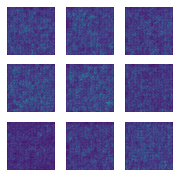

  0%|          | 0/120 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [67]:
# actual training loop
generate_and_save_images(vae, 0, test_sample)
for epoch in tqdm(range(1, epochs + 1)):
  start_time = time.time()
  train_loss = None
  for train_x, train_labels in tqdm(train_ds):
    train_x = train_x/255.
    train_labels = tf.one_hot(depth=len(class_names), indices=train_labels, dtype=tf.int32)
    train_loss = tf.reduce_mean(vae_train_step(train_x, train_labels, optimizer))
  end_time = time.time()
  train_time = end_time - start_time

  loss = tf.keras.metrics.Mean()
  start_time = time.time()
  val_loss = None
  for test_x, test_labels in val_ds:
      test_x = test_x/255.
      test_labels = tf.one_hot(depth=len(class_names), indices=test_labels)
      z_mean, z_logsigma, x_recon, y_logits = vae(test_x)
      vae_val_loss = VAE.vae_loss_function(test_x, x_recon, z_mean, z_logsigma)
      class_val_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_logits, labels=test_labels))
      val_loss = tf.reduce_mean(vae_val_loss + class_val_loss)
  end_time = time.time()
  val_time = end_time - start_time
  display.clear_output(wait=False)
  print('Epoch: {}\nTraining set KL loss : {}\nValidation set KL Loss: {},\ntime elapse for current epoch: training {} validation {}'
        .format(epoch, train_loss, val_loss, train_time, val_time))
  generate_and_save_images(vae, epoch, test_sample)

vae.save_models()